In [5]:
from sklearn.model_selection import train_test_split


In [1]:
from huggingface_hub import login
import pandas as pd

login()

# Dataset

In [3]:
# Login using e.g. `huggingface-cli login` to access this dataset
splits = {'train': 'train.json', 'test': 'test.json'}
train_df = pd.read_json("hf://datasets/jason23322/high-accuracy-email-classifier/" + splits["train"])
test_df = pd.read_json("hf://datasets/jason23322/high-accuracy-email-classifier/" + splits["test"])
# Load the two CSV files from our mock concert and flight emails
concert_df = pd.read_csv("mock_concert_emails.csv")
flight_df = pd.read_csv("mock_flight_emails.csv")

print(f"Concert emails shape: {concert_df.shape}")
print(f"Flight emails shape: {flight_df.shape}")

Concert emails shape: (1200, 6)
Flight emails shape: (1200, 6)


### Splitting our mock concert and flight emails CSV data 80/20 into training and testing

In [6]:
print("Splitting CSV data 80/20...")
# Combine the CSV files
csv_combined = pd.concat([concert_df, flight_df], ignore_index=True)
print(f"\nCombined CSV shape: {csv_combined.shape}")
print(f"Columns: {csv_combined.columns.tolist()}")

# Split CSV data 80/20 (stratified by category if available)
if 'category' in csv_combined.columns:
    csv_train, csv_test = train_test_split(
        csv_combined,
        test_size=0.2,
        random_state=42,
        stratify=csv_combined['category']
    )
else:
    csv_train, csv_test = train_test_split(
        csv_combined,
        test_size=0.2,
        random_state=42
    )

print(f"CSV Train set: {csv_train.shape} ({len(csv_train)/len(csv_combined)*100:.1f}%)")
print(f"CSV Test set: {csv_test.shape} ({len(csv_test)/len(csv_combined)*100:.1f}%)")

if 'category' in csv_combined.columns:
    print("\nCSV Train category distribution:")
    print(csv_train['category'].value_counts())
    print("\nCSV Test category distribution:")
    print(csv_test['category'].value_counts())


Splitting CSV data 80/20...

Combined CSV shape: (2400, 6)
Columns: ['subject', 'body', 'text', 'category', 'category_id', 'id']
CSV Train set: (1920, 6) (80.0%)
CSV Test set: (480, 6) (20.0%)

CSV Train category distribution:
category
flight_booking       960
concert_promotion    960
Name: count, dtype: int64

CSV Test category distribution:
category
flight_booking       240
concert_promotion    240
Name: count, dtype: int64


### Combining CSV of mock concert emails and mock flight emails splits with HuggingFace data and Save to CSV and JSON files

In [7]:
# Combine training data: HuggingFace train + CSV train
final_train = pd.concat([train_df, csv_train], ignore_index=True)
print(f"Final Train set: {final_train.shape}")
print(f"HuggingFace: {len(train_df)} rows")
print(f" CSV (80%)   : {len(csv_train)} rows")

# Combine testing data: HuggingFace test + CSV test
final_test = pd.concat([test_df, csv_test], ignore_index=True)
print(f"\nFinal Test set: {final_test.shape}")
print(f" HuggingFace: {len(test_df)} rows")
print(f"CSV (20%) of mock concert emails and mock flight emails: {len(csv_test)} rows")
# Save to CSV files
final_train.to_csv("combined_train.csv", index=False)
final_test.to_csv("combined_test.csv", index=False)

# Save to JSON files
final_train.to_json("combined_train.json", orient='records', lines=True)
final_test.to_json("combined_test.json", orient='records', lines=True)

print("Files saved successfully!")
print(f"combined_train.csv ({len(final_train)} rows)")
print(f"combined_test.csv ({len(final_test)} rows)")
print(f"combined_train.json ({len(final_train)} rows)")
print(f"combined_test.json ({len(final_test)} rows)")

Final Train set: (12700, 6)
HuggingFace: 10780 rows
 CSV (80%)   : 1920 rows

Final Test set: (3177, 6)
 HuggingFace: 2697 rows
CSV (20%) of mock concert emails and mock flight emails: 480 rows
Files saved successfully!
combined_train.csv (12700 rows)
combined_test.csv (3177 rows)
combined_train.json (12700 rows)
combined_test.json (3177 rows)


In [8]:
train_df = pd.read_csv("combined_train.csv")
test_df = pd.read_csv("combined_test.csv")

# Dataset Statistics & EDA

## Dataset Statistics

In [9]:
train_df.head()

,id,subject,body,text,category,category_id
0,promotions_582,Anniversary Special: Buy one get one free,"As our loyal customer, get exclusive $60 off $...",Anniversary Special: Buy one get one free As o...,promotions,1
1,spam_1629,Your Amazon was used on new device,Your $5000 refund is processed. Claim: bit.ly/...,Your Amazon was used on new device Your $5000 ...,spam,3
2,spam_322,Re: Your Google inquiry,"Hi, following up about your Google application...","Re: Your Google inquiry Hi, following up about...",spam,3
3,social_media_80,Digital Ritual Experience Creation,Cross-cultural ceremony design. Join: virtualr...,Digital Ritual Experience Creation Cross-cultu...,social_media,2
4,forum_1351,"Your post was moved to ""Programming Help""","Trending: ""cooking"" (258 comments). View: supp...","Your post was moved to ""Programming Help"" Tren...",forum,0


In [10]:
test_df.head()

,id,subject,body,text,category,category_id
0,social_media_1558,Watch later: Recommended story,"Group update: ""Book Club"" posted video. Trendi...","Watch later: Recommended story Group update: ""...",social_media,2
1,social_media_505,News from groups you follow,"Group ""Tech Enthusiasts"" invited you. RSVP: pl...","News from groups you follow Group ""Tech Enthus...",social_media,2
2,forum_190,Two-Factor Authentication Enforcement Notice,Required for all accounts by Dec 1: security.f...,Two-Factor Authentication Enforcement Notice R...,forum,0
3,updates_1851,Security upgrade: 2FA enabled,Your monthly statement is available. View/down...,Security upgrade: 2FA enabled Your monthly sta...,updates,4
4,verify_code_1753,Verification PIN: 907472,Use 404583 as your verification code. Device: ...,Verification PIN: 907472 Use 404583 as your ve...,verify_code,5


In [13]:


def quick_check(df, name="Dataset"):
    print(f"\n{name.upper()} — BASIC CHECKS")
    print("=" * 70)

    print("\nShape:", df.shape)
    print("Columns:", list(df.columns))

    print("\nData Types:")
    print(df.dtypes)

    print("\nInfo Summary:")
    df.info()

    print("\nMissing Values Per Column:")
    print(df.isnull().sum())

    print("\nEmpty String Counts (after strip):")
    empty_counts = (df.astype(str).apply(lambda x: x.str.strip() == "")).sum()
    empty_counts = empty_counts[empty_counts > 0]
    print("None" if empty_counts.empty else empty_counts.to_string())

    print("\nDuplicate Rows:", df.duplicated().sum())
    if "text" in df.columns:
        print("Duplicate 'text' entries:", df.duplicated(subset="text").sum())

    if "category" in df.columns:
        print("\nCategory Counts:")
        print(df["category"].value_counts())


def explore_dataset(df, name="Dataset"):
    print(f"\n{name.upper()} — SIMPLE EXPLORATION")
    print("=" * 70)

    if "category" in df.columns:
        cat_counts = df["category"].value_counts()
        cat_pct = (cat_counts / len(df) * 100).round(2)
        print("\nCategory Distribution (count):")
        print(cat_counts)
        print("\nCategory Distribution (%):")
        print(cat_pct.astype(str) + "%")

    if "text" in df.columns:
        text_len = df["text"].astype(str).str.len()
        print("\nText Length Statistics:")
        print(text_len.describe(percentiles=[.1, .25, .5, .75, .9]).round(2))

        if "category" in df.columns:
            print("\nAverage Text Length per Category:")
            print(
                df.assign(_text_len=text_len)
                  .groupby("category")["_text_len"]
                  .mean()
                  .round(2)
            )

    if "category" in df.columns:
        print("\nSample Emails (1 per category):")
        for cat in df["category"].unique():
            sample = df[df["category"] == cat].iloc[0]
            subj = str(sample["subject"]) if "subject" in df.columns else ""
            body = str(sample["body"])[:150] + "..." if "body" in df.columns else ""
            print(f"\nCategory: {cat}")
            print(f"Subject: {subj}")
            print(f"Body: {body}")
    else:
        cols = [c for c in ["subject", "body", "text"] if c in df.columns]
        if cols:
            print("\nSample Rows:")
            print(df[cols].head(3))


# Run both parts
quick_check(train_df, "Train Dataset")
quick_check(test_df, "Test Dataset")

explore_dataset(train_df, "Train Dataset")
explore_dataset(test_df, "Test Dataset")



TRAIN DATASET — BASIC CHECKS

Shape: (12700, 6)
Columns: ['id', 'subject', 'body', 'text', 'category', 'category_id']

Data Types:
id             object
subject        object
body           object
text           object
category       object
category_id     int64
dtype: object

Info Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12700 entries, 0 to 12699
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           12700 non-null  object
 1   subject      12700 non-null  object
 2   body         12700 non-null  object
 3   text         12700 non-null  object
 4   category     12700 non-null  object
 5   category_id  12700 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 595.4+ KB

Missing Values Per Column:
id             0
subject        0
body           0
text           0
category       0
category_id    0
dtype: int64

Empty String Counts (after strip):
None

Duplicate Rows: 0
Duplicate 'text'

In [14]:
def check_duplicates_by_category(df, name="Dataset"):
    print(f"\n{name.upper()} — DUPLICATE CHECK")
    print("=" * 70)

    # Count duplicates overall and by category
    total_dupes = df.duplicated(subset='text').sum()
    print(f"Total duplicate 'text' entries: {total_dupes}")

    dupes = df[df.duplicated(subset='text', keep=False)]
    if dupes.empty:
        print("No duplicate text entries found.")
        return

    print("\nDuplicates by category:")
    dupes_per_cat = dupes["category"].value_counts()
    print(dupes_per_cat)

    # Show example duplicate texts
    print("\nExample duplicate texts:")
    for text in dupes["text"].value_counts().head(5).index:
        cats = df.loc[df["text"] == text, "category"].unique()
        print(f"• Found {len(cats)} category overlap(s): {list(cats)}")

# Run before dropping duplicates
check_duplicates_by_category(train_df, "Train Dataset")
check_duplicates_by_category(test_df, "Test Dataset")

# Then drop duplicates safely
train_df = train_df.drop_duplicates(subset='text', keep='first').reset_index(drop=True)
test_df = test_df.drop_duplicates(subset='text', keep='first').reset_index(drop=True)

print("\nAfter dropping duplicates:")
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")



TRAIN DATASET — DUPLICATE CHECK
Total duplicate 'text' entries: 707

Duplicates by category:
category
updates         410
forum           382
social_media    191
spam            138
verify_code      52
promotions       51
Name: count, dtype: int64

Example duplicate texts:
• Found 1 category overlap(s): ['forum']
• Found 1 category overlap(s): ['updates']
• Found 1 category overlap(s): ['forum']
• Found 1 category overlap(s): ['updates']
• Found 1 category overlap(s): ['updates']

TEST DATASET — DUPLICATE CHECK
Total duplicate 'text' entries: 53

Duplicates by category:
category
updates         38
forum           29
spam            16
social_media    16
verify_code      2
promotions       2
Name: count, dtype: int64

Example duplicate texts:
• Found 1 category overlap(s): ['updates']
• Found 1 category overlap(s): ['forum']
• Found 1 category overlap(s): ['spam']
• Found 1 category overlap(s): ['spam']
• Found 1 category overlap(s): ['updates']

After dropping duplicates:
Train shape:

## Visualization

/tmp/ipython-input-460032022.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="category", y="words_per_sentence", data=df, palette="pastel")


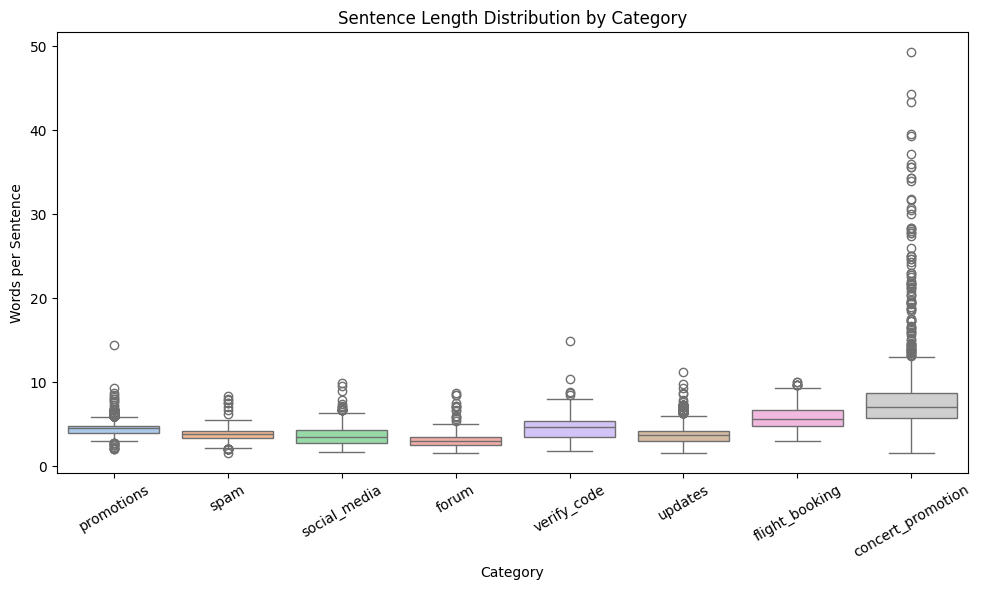

/tmp/ipython-input-460032022.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="category", y="word_count", data=df, inner="quartile", palette="muted")


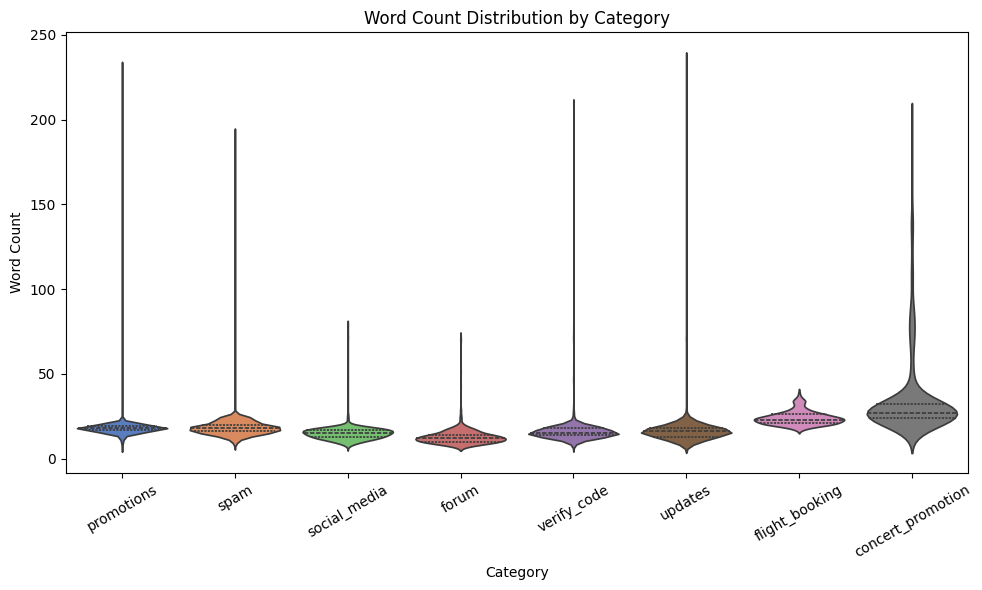


Top 20 Most Frequent Words (excluding <3-letter):
com             7239
your            4362
for             3415
code            2511
new             2369
off             1849
you             1728
now             1698
example         1597
flight          1503
site            1474
from            1414
view            1353
the             1353
support         1323
with            1190
live            1152
social          1125
account         1092
thread          1076


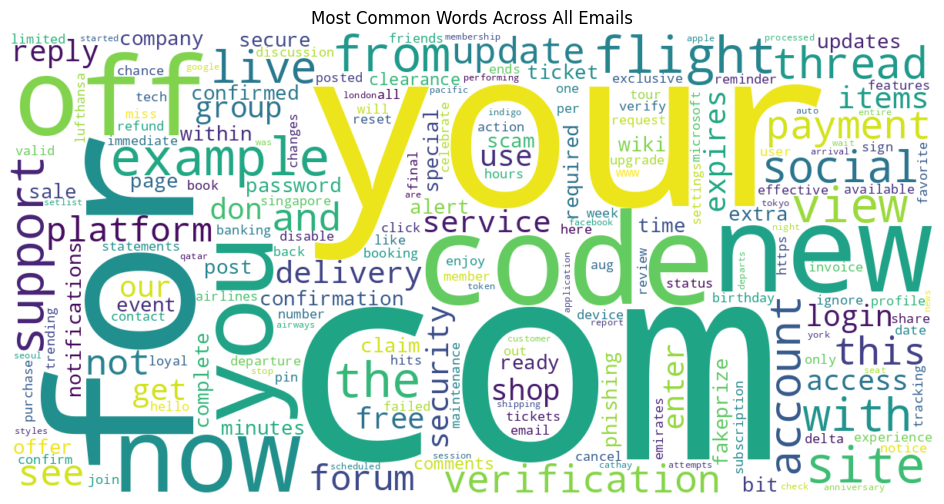

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re

# ---------------------------------------------------
#  Sentence length histogram per category
# ---------------------------------------------------
def plot_sentence_length_distribution(df):
    df["sentence_count"] = df["text"].apply(lambda x: len(re.split(r"[.!?]", str(x))) or 1)
    df["words_per_sentence"] = df["text"].apply(lambda x: len(str(x).split())) / df["sentence_count"]
    plt.figure(figsize=(10,6))
    sns.boxplot(x="category", y="words_per_sentence", data=df, palette="pastel")
    plt.title("Sentence Length Distribution by Category")
    plt.xlabel("Category")
    plt.ylabel("Words per Sentence")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------
# Word count distribution
#
# ---------------------------------------------------
def plot_wordcount_violin(df):
    df["word_count"] = df["text"].apply(lambda x: len(str(x).split()))
    plt.figure(figsize=(10,6))
    sns.violinplot(x="category", y="word_count", data=df, inner="quartile", palette="muted")
    plt.title("Word Count Distribution by Category")
    plt.xlabel("Category")
    plt.ylabel("Word Count")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------
# Repeated-word frequencies
# ---------------------------------------------------
def repeated_word_analysis(df):
    all_words = " ".join(df["text"].astype(str).tolist()).lower()
    words = re.findall(r"\b[a-zA-Z]{3,}\b", all_words)
    word_freq = Counter(words)
    most_common = word_freq.most_common(20)

    print("\nTop 20 Most Frequent Words (excluding <3-letter):")
    for w, c in most_common:
        print(f"{w:<15} {c}")

    # Optional: Word cloud
    wordcloud = WordCloud(width=1200, height=600, background_color="white").generate_from_frequencies(word_freq)
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most Common Words Across All Emails")
    plt.show()

# ---------------------------------------------------
# Run them on train data
# ---------------------------------------------------
plot_sentence_length_distribution(train_df)
plot_wordcount_violin(train_df)
repeated_word_analysis(train_df)


/tmp/ipython-input-3356009704.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


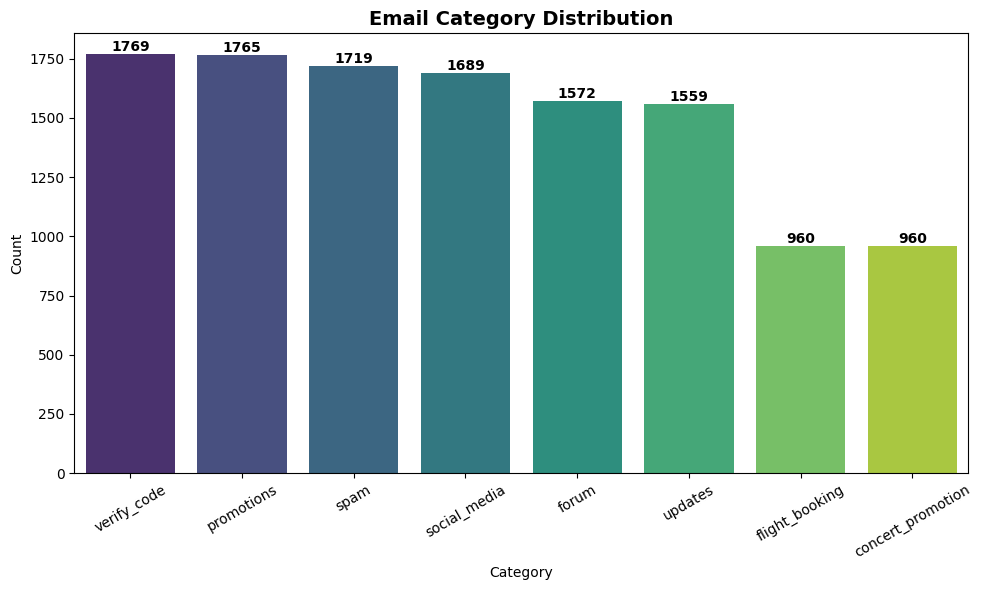

In [16]:
def plot_category_distribution(df):
    plt.figure(figsize=(10, 6))

    # Create count plot ordered by category frequency
    ax = sns.countplot(
        data=df,
        x="category",
        order=df["category"].value_counts().index,
        palette="viridis"  # Optional: adds color
    )

    # Title and labels
    plt.title("Email Category Distribution", fontsize=14, fontweight='bold')
    plt.xlabel("Category")
    plt.ylabel("Count")

    # Add counts on top of each bar
    for p in ax.patches:
        ax.annotate(
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom',
            fontsize=10, fontweight='bold'
        )

    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()
plot_category_distribution(train_df)

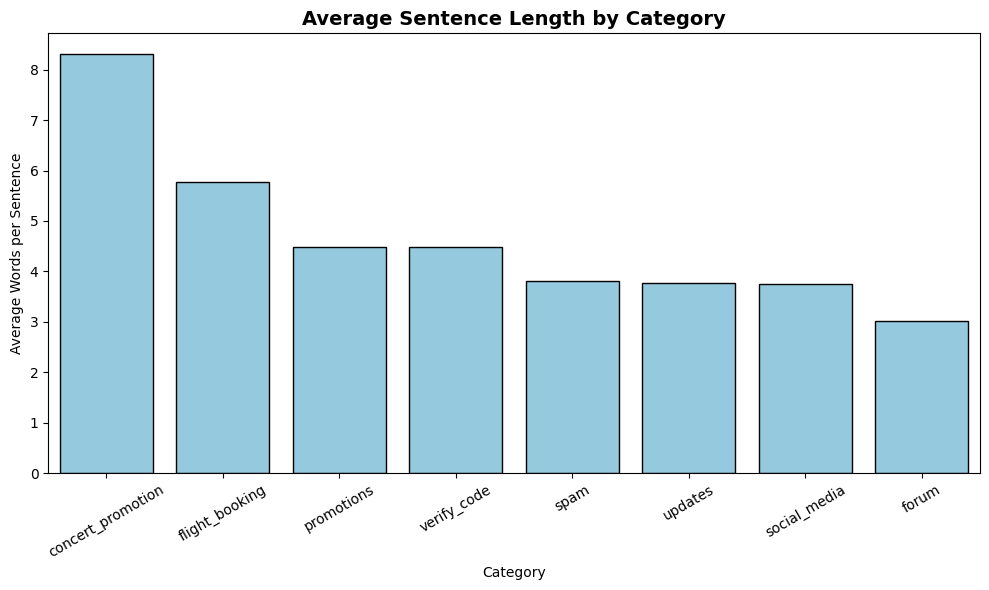

In [17]:
# Compute average words per sentence
def avg_sentence_length_plot(df):
    df["sentence_count"] = df["text"].apply(lambda x: len(re.split(r"[.!?]", str(x))) or 1)
    df["words_per_sentence"] = df["text"].apply(lambda x: len(str(x).split())) / df["sentence_count"]

    avg_len = df.groupby("category")["words_per_sentence"].mean().sort_values(ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x=avg_len.index, y=avg_len.values, color='skyblue', edgecolor='black')
    plt.title("Average Sentence Length by Category", fontsize=14, fontweight='bold')
    plt.xlabel("Category")
    plt.ylabel("Average Words per Sentence")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# Run it
avg_sentence_length_plot(train_df)

## Preprocessing

In [ ]:
import re
import math
import pandas as pd
from collections import Counter, defaultdict

URL_RE      = re.compile(r"(https?://\S+|www\.\S+)", re.I)
MONEY_RE    = re.compile(r"(\$|usd|eur|sgd|£|₹)\s?\d[\d,]*(?:\.\d+)?", re.I)
NUMBER_RE   = re.compile(r"\b\d+(?:[\.,]\d+)?\b")
EMOJI_RE    = re.compile(r"[\U0001F300-\U0001FAFF\U00002700-\U000027BF]")
HTML_RE     = re.compile(r"<[^>]+>")
REPLY_FWD_RE= re.compile(r"^\s*(re|fwd)\s*[:\-]", re.I)
PUNCT_RE    = re.compile(r"[^\w\s]")
NON_ASCII_RE= re.compile(r"[^\x00-\x7F]")
REPEAT_CHAR_RE = re.compile(r"(.)\1{3,}")  # 4+ same char in a row (e.g., !!!!! or cooooool)

def _safe_len_tokens(s):
    if not isinstance(s, str):
        return 0, 0
    txt = s.strip()
    if not txt:
        return 0, 0
    tokens = txt.split()
    return len(txt), len(tokens)

def _mk_text_col(df):
    if "text" in df.columns:
        return df["text"].astype(str)
    subj = df["subject"].astype(str) if "subject" in df.columns else ""
    body = df["body"].astype(str) if "body" in df.columns else ""
    return (subj + " " + body).str.strip()

def analyze_email_dataset(df: pd.DataFrame, text_col: str = None, min_tokens_short: int = 4):
    """
    Analyze an email-like dataset and propose cleaning steps.
    Returns: (report_dict, recommendations_list)
    """
    assert isinstance(df, pd.DataFrame), "df must be a pandas DataFrame"

    # Choose text column
    if text_col and text_col in df.columns:
        txt_series = df[text_col].astype(str)
        used_text_col = text_col
    else:
        txt_series = _mk_text_col(df)
        used_text_col = "text" if "text" in df.columns else "subject+body"

    n_rows = len(df)
    recs = []

    # Basic column checks
    required_cols = ["id", "subject", "body", "category", "category_id"]
    missing_cols = [c for c in required_cols if c not in df.columns]
    if missing_cols:
        recs.append(f"Add or derive missing columns: {missing_cols}")

    # NA / empty checks
    na_text = txt_series.isna().sum()
    empty_after_strip = (txt_series.str.strip() == "").sum()

    # Lengths & tokens
    lengths = txt_series.apply(lambda s: _safe_len_tokens(s)[0])
    token_counts = txt_series.apply(lambda s: _safe_len_tokens(s)[1])
    avg_chars = lengths.replace(0, pd.NA).mean()
    avg_tokens = token_counts.replace(0, pd.NA).mean()
    pct_too_short = (token_counts < min_tokens_short).mean() if n_rows else 0.0

    # Pattern counts
    url_counts = txt_series.str.count(URL_RE).fillna(0).astype(int)
    money_counts = txt_series.str.count(MONEY_RE).fillna(0).astype(int)
    number_counts = txt_series.str.count(NUMBER_RE).fillna(0).astype(int)
    emoji_counts = txt_series.str.count(EMOJI_RE).fillna(0).astype(int)
    html_counts = txt_series.str.count(HTML_RE).fillna(0).astype(int)
    reply_fwd_flags = txt_series.str.contains(REPLY_FWD_RE, na=False)
    punct_ratio = txt_series.apply(lambda s: (len(PUNCT_RE.findall(s)) / max(len(s),1)) if isinstance(s,str) else 0)
    non_ascii_ratio = txt_series.apply(lambda s: (len(NON_ASCII_RE.findall(s)) / max(len(s),1)) if isinstance(s,str) else 0)
    repeat_char_counts = txt_series.str.count(REPEAT_CHAR_RE).fillna(0).astype(int)

    # Duplicates / near duplicates
    # Exact duplicates
    dupe_exact = txt_series.duplicated(keep=False).sum()
    # ID duplicates
    dupe_ids = df["id"].duplicated(keep=False).sum() if "id" in df.columns else 0

    # Label distribution
    cat_counts = df["category"].value_counts(dropna=False) if "category" in df.columns else pd.Series(dtype=int)
    cat_id_counts = df["category_id"].value_counts(dropna=False) if "category_id" in df.columns else pd.Series(dtype=int)

    # Heuristic recommendations
    if na_text > 0 or empty_after_strip > 0:
        recs.append(f"Drop rows with missing/empty {used_text_col} ({na_text} NA, {empty_after_strip} empty).")

    if dupe_exact > 0:
        recs.append(f"Drop exact duplicate texts ({dupe_exact} rows).")
    if dupe_ids > 0:
        recs.append(f"Investigate duplicate IDs ({dupe_ids} rows). Keep the earliest or most complete.")

    if pct_too_short > 0.02:
        recs.append(f"Remove ultra-short messages (<{min_tokens_short} tokens): {pct_too_short:.1%} of data (e.g., 'hello', 'ok').")

    if url_counts.any():
        recs.append("Normalize or replace URLs with a placeholder token (e.g., 'URL').")

    if money_counts.any():
        recs.append("Normalize currency/amounts to 'MONEY' to reduce numeric variance.")

    if number_counts.mean() > 0.3:
        recs.append("Normalize general numbers to 'NUMBER' (lots of numeric noise).")

    if html_counts.any():
        recs.append("Strip HTML tags (found HTML-like markup in text).")

    if emoji_counts.mean() > 0:
        recs.append("Optionally remove or map emojis to tokens (depends on your model).")

    high_punct_rows = (punct_ratio > 0.2).mean()  # 20%+ of chars are punctuation
    if high_punct_rows > 0.02:
        recs.append(f"Reduce excessive punctuation (>{20}% of chars) in {high_punct_rows:.1%} of rows.")

    high_non_ascii_rows = (non_ascii_ratio > 0.05).mean()
    if high_non_ascii_rows > 0.02:
        recs.append(f"Normalize or remove non-ASCII noise (non-Latin chars >5% of text) in {high_non_ascii_rows:.1%} of rows.")

    if reply_fwd_flags.mean() > 0.05:
        recs.append(f"Strip leading 'Re:'/'Fwd:' prefixes in subjects (~{reply_fwd_flags.mean():.1%} of items).")

    if repeat_char_counts.mean() > 0:
        recs.append("Collapse repeated characters (e.g., 'cooool'→'cool', '!!!!!'→'!!').")

    # Class imbalance hint
    if not cat_counts.empty:
        top_share = (cat_counts.max() / max(cat_counts.sum(), 1))
        if top_share > 0.55:
            recs.append(f"Class imbalance detected (top class ≈ {top_share:.0%}). Consider class weights or resampling.")

    # Compose report
    report = {
        "rows": n_rows,
        "used_text_col": used_text_col,
        "na_text": int(na_text),
        "empty_after_strip": int(empty_after_strip),
        "avg_chars": float(0 if math.isnan(avg_chars) else avg_chars),
        "avg_tokens": float(0 if math.isnan(avg_tokens) else avg_tokens),
        "pct_too_short(<{} tokens)".format(min_tokens_short): float(pct_too_short),
        "duplicates_text_exact": int(dupe_exact),
        "duplicates_id": int(dupe_ids),
        "mean_urls_per_row": float(url_counts.mean()),
        "mean_money_mentions_per_row": float(money_counts.mean()),
        "mean_numbers_per_row": float(number_counts.mean()),
        "mean_emojis_per_row": float(emoji_counts.mean()),
        "rows_with_html": int((html_counts > 0).sum()),
        "rows_reply_or_fwd_subject": int(reply_fwd_flags.sum()),
        "rows_high_punct_ratio(>0.2)": int((punct_ratio > 0.2).sum()),
        "rows_high_non_ascii_ratio(>0.05)": int((non_ascii_ratio > 0.05).sum()),
        "rows_repeat_chars(>=4)": int((repeat_char_counts > 0).sum()),
        "category_counts": cat_counts.to_dict() if not cat_counts.empty else {},
        "category_id_counts": cat_id_counts.to_dict() if not cat_id_counts.empty else {},
    }

    # Always include a sensible, minimal cleaning recipe at the end
    minimal_recipe = [
        "Lowercase",
        "Replace URLs→'URL', currency→'MONEY', numbers→'NUMBER'",
        "Strip HTML tags",
        "Trim leading 'Re:'/'Fwd:' in subject",
        "Collapse repeated punctuation/letters",
        f"Drop empty and ultra-short (<{min_tokens_short} tokens) rows",
        "Drop exact duplicates",
    ]
    report["minimal_cleaning_recipe"] = minimal_recipe

    # Deduplicate recommendations while preserving order
    seen = set()
    recs_unique = []
    for r in recs:
        if r not in seen:
            recs_unique.append(r)
            seen.add(r)

    return report, recs_unique

In [ ]:
report, recommendations = analyze_email_dataset(train_df)
print("=== Summary ===")
for k, v in report.items():
    if k not in {"category_counts", "category_id_counts"}:
        print(f"{k}: {v}")

print("\n=== Category distribution ===")
print(report["category_counts"])

print("\n=== Cleaning recommendations ===")
for i, r in enumerate(recommendations, 1):
    print(f"{i}. {r}")

=== Summary ===
rows: 10780
used_text_col: text
na_text: 0
empty_after_strip: 0
avg_chars: 124.58877551020409
avg_tokens: 16.033024118738403
pct_too_short(<4 tokens): 0.0
duplicates_text_exact: 1224
duplicates_id: 0
mean_urls_per_row: 0.0
mean_money_mentions_per_row: 0.1474025974025974
mean_numbers_per_row: 1.6183673469387756
mean_emojis_per_row: 0.0
rows_with_html: 0
rows_reply_or_fwd_subject: 62
rows_high_punct_ratio(>0.2): 0
rows_high_non_ascii_ratio(>0.05): 0
rows_repeat_chars(>=4): 138
minimal_cleaning_recipe: ['Lowercase', "Replace URLs→'URL', currency→'MONEY', numbers→'NUMBER'", 'Strip HTML tags', "Trim leading 'Re:'/'Fwd:' in subject", 'Collapse repeated punctuation/letters', 'Drop empty and ultra-short (<4 tokens) rows', 'Drop exact duplicates']

=== Category distribution ===
{'verify_code': 1800, 'forum': 1800, 'social_media': 1796, 'promotions': 1796, 'spam': 1794, 'updates': 1794}

=== Cleaning recommendations ===
1. Drop exact duplicate texts (1224 rows).
2. Normalize curr

/tmp/ipython-input-797122591.py:73: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  reply_fwd_flags = txt_series.str.contains(REPLY_FWD_RE, na=False)


In [ ]:
print(f"Total rows: {len(train_df):,}")
print(f"Columns: {list(train_df.columns)}")
print(f"Missing values total: {train_df.isnull().sum().sum()}")
print(f"Duplicate text entries: {train_df.duplicated(subset='text').sum()}")

Total rows: 10,780
Columns: ['id', 'subject', 'body', 'text', 'category', 'category_id']
Missing values total: 0
Duplicate text entries: 707


In [ ]:
import re
import pandas as pd

# Non-capturing groups to avoid pandas warnings
URL_RE          = r"(https?://\S+|www\.\S+)"
MONEY_RE        = r"(?:\$|usd|eur|sgd|£|₹)\s?\d[\d,]*(?:\.\d+)?"
NUMBER_TOKEN_RE = r"\b\d+(?:[\.,]\d+)?\b"
HTML_RE         = r"<[^>]+>"
REPEAT_CHAR_RE  = re.compile(r"(.)\1{3,}")                 # used in .apply
REPLY_FWD_RE    = re.compile(r"^\s*(?:re|fwd)\s*[:\-]", re.I)

def _collapse_repeats_str(s: str) -> str:
    return re.sub(REPEAT_CHAR_RE, r"\1\1", s) if isinstance(s, str) else s

def _trim_reply_fwd_subject(subj: str) -> str:
    return re.sub(REPLY_FWD_RE, "", subj).strip() if isinstance(subj, str) else subj

def build_text(df: pd.DataFrame) -> pd.Series:
    subj = df["subject"].astype("string") if "subject" in df.columns else pd.Series("", index=df.index, dtype="string")
    body = df["body"].astype("string")    if "body"    in df.columns else pd.Series("", index=df.index, dtype="string")
    return (subj.fillna("") + " " + body.fillna("")).str.strip()

def clean_dataset(
    df: pd.DataFrame,
    *,
    use_col: str | None = "text",
    drop_exact_dupes: bool = True,
    strip_html: bool = False,     # your scan shows 0 HTML
    trim_reply_fwd: bool = True,  # you have 62
    lowercase: bool = True
) -> tuple[pd.DataFrame, dict]:
    """Returns (df_clean, log). Adds a new column df['text_clean'] and optionally 'subject_clean'."""
    out = df.copy()

    # Subject cleanup (vectorized via .apply only for the prefix trim)
    if trim_reply_fwd and "subject" in out.columns:
        out["subject_clean"] = out["subject"].astype("string").fillna("").apply(_trim_reply_fwd_subject)
    elif "subject" in out.columns:
        out["subject_clean"] = out["subject"].astype("string").fillna("")

    # Choose raw text
    if use_col and use_col in out.columns:
        raw = out[use_col].astype("string").fillna("")
    else:
        raw = build_text(out)

    # --- Vectorized cleaning on the Series ---
    txt = raw

    # Normalize URLs / MONEY / NUMBER
    txt = txt.str.replace(URL_RE, " URL ", regex=True)
    txt = txt.str.replace(MONEY_RE, " MONEY ", regex=True)
    txt = txt.str.replace(NUMBER_TOKEN_RE, " NUMBER ", regex=True)

    # Optional HTML strip
    if strip_html:
        txt = txt.str.replace(HTML_RE, " ", regex=True)

    # Collapse repeated chars (needs .apply)
    txt = txt.apply(_collapse_repeats_str)

    # Lowercase & whitespace normalize
    if lowercase:
        txt = txt.str.lower()
    txt = txt.str.replace(r"\s+", " ", regex=True).str.strip()

    out["text_clean"] = txt

    # Drop empties (safe-guard)
    before = len(out)
    out = out[out["text_clean"].str.len() > 0]
    dropped_empty = before - len(out)

    # Drop exact duplicates
    dupe_dropped = 0
    if drop_exact_dupes:
        before = len(out)
        out = out.drop_duplicates(subset=["text_clean"])
        dupe_dropped = before - len(out)

    log = {
        "rows_before": len(df),
        "rows_after": len(out),
        "dropped_empty": int(dropped_empty),
        "dropped_exact_duplicates": int(dupe_dropped),
        "lowercased": lowercase,
        "normalized_money": True,
        "normalized_numbers": True,
        "normalized_urls": True,
        "collapsed_repeats": True,
        "trimmed_reply_fwd_subject": bool(trim_reply_fwd and "subject" in df.columns),
        "html_stripped": strip_html,
    }
    return out, log

In [ ]:
df_clean, log = clean_dataset(train_df, use_col="text", strip_html=False, trim_reply_fwd=True)
print(log)

{'rows_before': 10780, 'rows_after': 8444, 'dropped_empty': 0, 'dropped_exact_duplicates': 2336, 'lowercased': True, 'normalized_money': True, 'normalized_numbers': True, 'normalized_urls': True, 'collapsed_repeats': True, 'trimmed_reply_fwd_subject': True, 'html_stripped': False}


In [ ]:
df_clean, log = clean_dataset(train_df, use_col="text", strip_html=False, trim_reply_fwd=True)
print(log)
print("Example before/after:")
print(train_df.loc[0, "text"][:120], "...")
print(df_clean.loc[df_clean.index[0], "text_clean"][:120], "...")

{'rows_before': 10780, 'rows_after': 8444, 'dropped_empty': 0, 'dropped_exact_duplicates': 2336, 'lowercased': True, 'normalized_money': True, 'normalized_numbers': True, 'normalized_urls': True, 'collapsed_repeats': True, 'trimmed_reply_fwd_subject': True, 'html_stripped': False}
Example before/after:
Anniversary Special: Buy one get one free As our loyal customer, get exclusive $60 off $75+: example.com/6058 Offer code ...
anniversary special: buy one get one free as our loyal customer, get exclusive money off money +: example.com/ number of ...


In [ ]:
df_clean

,id,subject,body,text,category,category_id,subject_clean,text_clean
0,promotions_582,Anniversary Special: Buy one get one free,"As our loyal customer, get exclusive $60 off $...",Anniversary Special: Buy one get one free As o...,promotions,1,Anniversary Special: Buy one get one free,anniversary special: buy one get one free as o...
1,spam_1629,Your Amazon was used on new device,Your $5000 refund is processed. Claim: bit.ly/...,Your Amazon was used on new device Your $5000 ...,spam,3,Your Amazon was used on new device,your amazon was used on new device your money ...
2,spam_322,Re: Your Google inquiry,"Hi, following up about your Google application...","Re: Your Google inquiry Hi, following up about...",spam,3,Your Google inquiry,"re: your google inquiry hi, following up about..."
3,social_media_80,Digital Ritual Experience Creation,Cross-cultural ceremony design. Join: virtualr...,Digital Ritual Experience Creation Cross-cultu...,social_media,2,Digital Ritual Experience Creation,digital ritual experience creation cross-cultu...
4,forum_1351,"Your post was moved to ""Programming Help""","Trending: ""cooking"" (258 comments). View: supp...","Your post was moved to ""Programming Help"" Tren...",forum,0,"Your post was moved to ""Programming Help""","your post was moved to ""programming help"" tren..."
...,...,...,...,...,...,...,...,...
10773,social_media_1856,John Smith liked your video,"""Great insight!"" View: social.com/notification...","John Smith liked your video ""Great insight!"" V...",social_media,2,John Smith liked your video,"john smith liked your video ""great insight!"" v..."
10774,updates_568,Reservation confirmed: Restaurant #12AB34,ABC Airlines Main pool closed Aug 20-22 for ma...,Reservation confirmed: Restaurant #12AB34 ABC ...,updates,4,Reservation confirmed: Restaurant #12AB34,reservation confirmed: restaurant #12ab34 abc ...
10775,social_media_2213,News: Mike Chen started new position,View profile: platform.com/users/sarah Accept/...,News: Mike Chen started new position View prof...,social_media,2,News: Mike Chen started new position,news: mike chen started new position view prof...
10777,spam_906,Security alert: 5 failed login attempts,MacBook Air logged in 6hrs minutes ago. Verify...,Security alert: 5 failed login attempts MacBoo...,spam,3,Security alert: 5 failed login attempts,security alert: number failed login attempts m...


In [ ]:
import random, numpy as np, pandas as pd, torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
from typing import Dict, List, Tuple

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

PAD, UNK = "<pad>", "<unk>"

# ----- utils -----
def build_label_maps(labels: List[str]) -> Tuple[Dict[str,int], List[str]]:
    classes = sorted(set(labels))
    return {c:i for i,c in enumerate(classes)}, classes

def build_vocab(texts: List[str], max_vocab=25_000, min_freq=2) -> Tuple[Dict[str,int], List[str]]:
    counter = Counter()
    for t in texts: counter.update(t.split())
    tokens = [t for t,c in counter.items() if c >= min_freq]
    tokens.sort(key=lambda x: (-counter[x], x))
    vocab = [PAD, UNK] + tokens[: max_vocab - 2]
    word_index = {w:i for i,w in enumerate(vocab)}
    return word_index, vocab

def text_to_ids(text: str, word_index: Dict[str,int], max_len=250, pad_idx=0, oov_idx=1) -> List[int]:
    ids = [word_index.get(tok, oov_idx) for tok in text.split()]
    if len(ids) > max_len: ids = ids[:max_len]
    if len(ids) < max_len: ids += [pad_idx] * (max_len - len(ids))
    return ids

class EmailDataset(Dataset):
    def __init__(self, texts: List[str], y: List[int], word_index: Dict[str,int], max_len=250):
        self.texts, self.y, self.word_index, self.max_len = texts, y, word_index, max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        ids = torch.tensor(text_to_ids(self.texts[i], self.word_index, self.max_len), dtype=torch.long)
        mask = (ids != 0).long()
        label = torch.tensor(self.y[i], dtype=torch.long)
        return {"input_ids": ids, "attention_mask": mask, "labels": label}

def compute_class_weights(y: np.ndarray, num_classes: int) -> torch.Tensor:
    counts = np.bincount(y, minlength=num_classes).astype(np.float64)
    inv = 1.0 / np.clip(counts, 1, None)
    w = inv * (counts.sum() / (num_classes * counts))
    return torch.tensor(w, dtype=torch.float)

# ----- main -----
def prep_textclean_category(
    df: pd.DataFrame,
    max_len=250, max_vocab=25_000, min_freq=2,
    test_size=0.1, val_size=0.1,
    batch_size=64, num_workers=2
):
    assert "text_clean" in df.columns and "category" in df.columns

    # keep only needed + tidy + drop dupes
    work = df[["text_clean", "category"]].copy()
    work["text_clean"] = work["text_clean"].astype("string").str.strip()
    work = work[work["text_clean"].str.len() > 0]
    before = len(work)
    work = work.drop_duplicates(subset=["text_clean"])
    dropped_dupes = before - len(work)

    # labels
    labels_str = work["category"].astype(str).tolist()
    label2id, id2label = build_label_maps(labels_str)
    y_all = np.array([label2id[s] for s in labels_str], dtype=np.int64)
    texts_all = work["text_clean"].astype(str).tolist()

    # stratified splits
    X_tmp, X_test, y_tmp, y_test = train_test_split(
        texts_all, y_all, test_size=test_size, random_state=SEED, stratify=y_all
    )
    val_ratio_adj = val_size / (1.0 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_tmp, y_tmp, test_size=val_ratio_adj, random_state=SEED, stratify=y_tmp
    )

    # vocab on TRAIN ONLY
    word_index, index2word = build_vocab(X_train, max_vocab=max_vocab, min_freq=min_freq)

    # datasets
    ds_train = EmailDataset(X_train, y_train.tolist(), word_index, max_len=max_len)
    ds_val   = EmailDataset(X_val,   y_val.tolist(),   word_index, max_len=max_len)
    ds_test  = EmailDataset(X_test,  y_test.tolist(),  word_index, max_len=max_len)

    # loaders
    mk = lambda ds, sh=False: DataLoader(ds, batch_size=batch_size, shuffle=sh, num_workers=num_workers, pin_memory=True)
    dl_train, dl_val, dl_test = mk(ds_train, True), mk(ds_val), mk(ds_test)

    # class weights from TRAIN
    class_weights = compute_class_weights(y_train, num_classes=len(id2label))

    stats = {
        "rows_in": len(df),
        "rows_used": len(work),
        "dropped_exact_dupes": int(dropped_dupes),
        "vocab_size": len(index2word),
        "num_classes": len(id2label),
        "splits": {"train": len(ds_train), "val": len(ds_val), "test": len(ds_test)},
        "label2id": label2id,
        "id2label": {i:c for i,c in enumerate(id2label)},
    }

    return {
        "word_index": word_index, "index2word": index2word,
        "label2id": label2id, "id2label": id2label,
        "dl_train": dl_train, "dl_val": dl_val, "dl_test": dl_test,
        "class_weights": class_weights,
        "stats": stats,
    }




In [ ]:
bundle = prep_textclean_category(df_clean, max_len=250, max_vocab=25_000, min_freq=2,
                                 test_size=0.1, val_size=0.1, batch_size=64)

print(bundle["stats"])
class_weights = bundle["class_weights"]

{'rows_in': 8444, 'rows_used': 8444, 'dropped_exact_dupes': 0, 'vocab_size': 2337, 'num_classes': 6, 'splits': {'train': 6754, 'val': 845, 'test': 845}, 'label2id': {'forum': 0, 'promotions': 1, 'social_media': 2, 'spam': 3, 'updates': 4, 'verify_code': 5}, 'id2label': {0: 'forum', 1: 'promotions', 2: 'social_media', 3: 'spam', 4: 'updates', 5: 'verify_code'}}


# Model

# MPNET + RF

In [ ]:
# ============================================
# MPNet embeddings  →  RandomForest classifier
# Input: df_clean['text_clean'] ; Target: df_clean['category']
# ============================================
!pip -q install -U sentence-transformers

import os, random, numpy as np, pandas as pd, torch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm

# ---------- Config & Repro ----------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"  # 768-dim

# ---------- Expect df_clean with ['text_clean', 'category'] ----------
assert "text_clean" in df_clean.columns and "category" in df_clean.columns, "Need text_clean and category columns"

# Drop empties & exact duplicates on text_clean (safe)
work = df_clean[["text_clean", "category"]].copy()
work["text_clean"] = work["text_clean"].astype(str).str.strip()
work = work[work["text_clean"].str.len() > 0]
work = work.drop_duplicates(subset=["text_clean"]).reset_index(drop=True)

# ---------- Stratified split (train/val/test) ----------
X = work["text_clean"].tolist()
y = work["category"].astype(str).tolist()

X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=SEED, stratify=y
)
val_ratio_adj = 0.1 / (1.0 - 0.1)  # 10% of remaining
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=val_ratio_adj, random_state=SEED, stratify=y_tmp
)

classes = sorted(list(set(y_train + y_val + y_test)))
print("Classes:", classes)
print(f"Sizes → train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")

# ---------- MPNet encoder ----------
encoder = SentenceTransformer(MODEL_NAME, device=DEVICE)

def embed_texts(texts, batch_size=128, normalize=True):
    """Return (N, 768) embeddings as float32 numpy array."""
    embs = encoder.encode(
        texts,
        batch_size=batch_size,
        convert_to_numpy=True,
        show_progress_bar=True,
        device=DEVICE,
        normalize_embeddings=normalize,  # cosine-friendly
    )
    return embs.astype(np.float32)

# Cache to speed up re-runs
os.makedirs("emb_cache", exist_ok=True)
def cache_or_compute(name, texts):
    path = f"emb_cache/{name}.npy"
    if os.path.exists(path):
        return np.load(path)
    arr = embed_texts(texts)
    np.save(path, arr)
    return arr

Xtr = cache_or_compute("mpnet_train", X_train)
Xva = cache_or_compute("mpnet_val",   X_val)
Xte = cache_or_compute("mpnet_test",  X_test)

# ---------- Random Forest ----------
# Balanced_subsample helps with mild imbalance; increase n_estimators for extra stability
clf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=SEED,
)

clf.fit(Xtr, y_train)

# Validation quick check (optional)
yva_pred = clf.predict(Xva)
print("VAL  acc:", accuracy_score(y_val, yva_pred))
print("VAL  f1 (macro):", f1_score(y_val, yva_pred, average="macro"))

# ---------- Test evaluation ----------
yte_pred = clf.predict(Xte)
print("\nTEST acc:", accuracy_score(y_test, yte_pred))
print("TEST f1 (macro):", f1_score(y_test, yte_pred, average="macro"))
print("\nClassification report (TEST):")
print(classification_report(y_test, yte_pred, labels=classes, digits=4))

Classes: ['forum', 'promotions', 'social_media', 'spam', 'updates', 'verify_code']
Sizes → train=6754, val=845, test=845


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

VAL  acc: 0.9644970414201184
VAL  f1 (macro): 0.9640737885848791

TEST acc: 0.9633136094674556
TEST f1 (macro): 0.9629547066190712

Classification report (TEST):
              precision    recall  f1-score   support

       forum     0.9459    0.9722    0.9589       144
  promotions     1.0000    0.8909    0.9423       110
social_media     0.9360    0.9877    0.9612       163
        spam     0.9875    0.9518    0.9693       166
     updates     0.9481    0.9799    0.9637       149
 verify_code     0.9823    0.9823    0.9823       113

    accuracy                         0.9633       845
   macro avg     0.9666    0.9608    0.9630       845
weighted avg     0.9645    0.9633    0.9632       845



# MPNET + XGboost

In [ ]:
# ============================================
# MPNet embeddings  →  XGBoost classifier
# Input: df_clean['text_clean'] ; Target: df_clean['category']
# ============================================
!pip -q install -U sentence-transformers xgboost

import os, random, numpy as np, pandas as pd, torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import xgboost as xgb

# ---------- Config & Repro ----------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"  # 768-dim

# ---------- Expect df_clean with ['text_clean', 'category'] ----------
assert "text_clean" in df_clean.columns and "category" in df_clean.columns, "Need text_clean and category columns"

# Drop empties & exact duplicates on text_clean (safe)
work = df_clean[["text_clean", "category"]].copy()
work["text_clean"] = work["text_clean"].astype(str).str.strip()
work = work[work["text_clean"].str.len() > 0]
work = work.drop_duplicates(subset=["text_clean"]).reset_index(drop=True)

# ---------- Stratified split (train/val/test) ----------
X = work["text_clean"].tolist()
y = work["category"].astype(str).tolist()

X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=SEED, stratify=y
)
val_ratio_adj = 0.1 / (1.0 - 0.1)  # 10% of remaining -> val
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=val_ratio_adj, random_state=SEED, stratify=y_tmp
)

print(f"Sizes → train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")

# ---------- Label encoding ----------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)
classes = le.classes_
num_classes = len(classes)
print("Classes:", list(classes))

# ---------- MPNet encoder ----------
encoder = SentenceTransformer(MODEL_NAME, device=DEVICE)

def embed_texts(texts, batch_size=128, normalize=True):
    """Return (N, 768) embeddings as float32 numpy array."""
    embs = encoder.encode(
        texts,
        batch_size=batch_size,
        convert_to_numpy=True,
        show_progress_bar=True,
        device=DEVICE,
        normalize_embeddings=normalize,  # cosine-friendly
    )
    return embs.astype(np.float32)

# Cache to speed up re-runs
os.makedirs("emb_cache", exist_ok=True)
def cache_or_compute(name, texts):
    path = f"emb_cache/{name}.npy"
    if os.path.exists(path):
        return np.load(path)
    arr = embed_texts(texts)
    np.save(path, arr)
    return arr

Xtr = cache_or_compute("mpnet_train", X_train)
Xva = cache_or_compute("mpnet_val",   X_val)
Xte = cache_or_compute("mpnet_test",  X_test)

# ---------- Sample weights (inverse frequency, mean≈1) ----------
counts = np.bincount(y_train_enc, minlength=num_classes).astype(np.float64)
class_w = counts.mean() / np.clip(counts, 1, None)
sample_w = class_w[y_train_enc]

print("Class weights (train):", {cls: round(class_w[i], 4) for i, cls in enumerate(classes)})

# ---------- XGBoost multiclass ----------
params = {
    "objective": "multi:softprob",
    "num_class": num_classes,
    "eval_metric": "mlogloss",
    "learning_rate": 0.05,
    "n_estimators": 800,
    "max_depth": 8,
    "subsample": 0.9,
    "colsample_bytree": 0.8,
    "reg_lambda": 1.0,
    "reg_alpha": 0.0,
    "tree_method": "hist",
    "random_state": SEED,
    "n_jobs": -1,
}

clf = xgb.XGBClassifier(**params)
clf.fit(
    Xtr, y_train_enc,
    sample_weight=sample_w,
    eval_set=[(Xva, y_val_enc)],
    verbose=False
)

# ---------- Validation (quick) ----------
yva_pred = clf.predict(Xva)
print("VAL  acc:", accuracy_score(y_val_enc, yva_pred))
print("VAL  f1 (macro):", f1_score(y_val_enc, yva_pred, average="macro"))

# ---------- Test evaluation ----------
yte_pred = clf.predict(Xte)
print("\nTEST acc:", accuracy_score(y_test_enc, yte_pred))
print("TEST f1 (macro):", f1_score(y_test_enc, yte_pred, average="macro"))
print("\nClassification report (TEST):")
print(classification_report(y_test_enc, yte_pred, target_names=classes, digits=4))

Sizes → train=6754, val=845, test=845
Classes: [np.str_('forum'), np.str_('promotions'), np.str_('social_media'), np.str_('spam'), np.str_('updates'), np.str_('verify_code')]
Class weights (train): {np.str_('forum'): np.float64(0.9754), np.str_('promotions'): np.float64(1.2865), np.str_('social_media'): np.float64(0.8632), np.str_('spam'): np.float64(0.8496), np.str_('updates'): np.float64(0.9459), np.str_('verify_code'): np.float64(1.2425)}
VAL  acc: 0.9668639053254438
VAL  f1 (macro): 0.9669299789644271

TEST acc: 0.9668639053254438
TEST f1 (macro): 0.9668091406397571

Classification report (TEST):
              precision    recall  f1-score   support

       forum     0.9857    0.9583    0.9718       144
  promotions     0.9808    0.9273    0.9533       110
social_media     0.9314    1.0000    0.9645       163
        spam     0.9812    0.9458    0.9632       166
     updates     0.9667    0.9732    0.9699       149
 verify_code     0.9655    0.9912    0.9782       113

    accuracy

## TextCNNBiGRUAttn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextCNNBiGRUAttn(nn.Module):
    """
    Architecture:
      Input (B, 250)
        → Embedding (V=25k, D=300)
        → Multi-scale CNN over time (k = 3,4,5, same-length)
        → BiGRU (hidden per dir=128 → 256 total features)
        → Multi-Head Self-Attention (8 heads)
        → Global pooling (mean + max)
        → Dense + Dropout
        → Output logits (6)
    """
    def __init__(
        self,
        vocab_size: int = 25_000,
        embed_dim: int = 300,
        pad_idx: int = 0,
        cnn_channels: int = 128,     # per kernel
        kernels=(3, 4, 5),
        gru_hidden: int = 128,       # per direction → 256 total
        num_heads: int = 8,
        fc_hidden: int = 128,
        num_classes: int = 6,
        dropout: float = 0.3,
        freeze_embed: bool = False,
    ):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        if freeze_embed:
            for p in self.embed.parameters():
                p.requires_grad = False

        # Multi-scale temporal CNN (Conv1d expects [B, C_in, T])
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embed_dim,
                out_channels=cnn_channels,
                kernel_size=k,
                padding=k // 2,       # "same" length for odd k
            )
            for k in kernels
        ])
        conv_out_dim = cnn_channels * len(kernels)

        # Project CNN concat → GRU input size
        self.proj = nn.Linear(conv_out_dim, gru_hidden * 2)  # match BiGRU input

        # BiGRU (batch_first=True → [B, T, F])
        self.gru = nn.GRU(
            input_size=gru_hidden * 2,
            hidden_size=gru_hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        gru_out_dim = gru_hidden * 2  # 256 total as requested

        # Multi-head self-attention (batch_first for convenience)
        self.attn = nn.MultiheadAttention(
            embed_dim=gru_out_dim,
            num_heads=num_heads,
            batch_first=True,
        )

        # Final MLP head: we concatenate mean & max pool → 2 * gru_out_dim
        pooled_dim = gru_out_dim * 2
        self.fc = nn.Sequential(
            nn.Linear(pooled_dim, fc_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_hidden, fc_hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_hidden // 2, num_classes),
        )

        self.dropout = nn.Dropout(dropout)
        self._init_weights()

    def _init_weights(self):
        # Kaiming for convs/linear; xavier for proj/attn; embeddings default
        for conv in self.convs:
            nn.init.kaiming_normal_(conv.weight, nonlinearity='relu')
            if conv.bias is not None:
                nn.init.zeros_(conv.bias)
        for m in self.fc:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)
        nn.init.xavier_uniform_(self.proj.weight)
        nn.init.zeros_(self.proj.bias)

    def forward(
        self,
        input_ids: torch.Tensor,          # [B, T]
        attention_mask: torch.Tensor = None,  # [B, T], 1 for real tokens, 0 for pad
    ):
        # Embedding
        x = self.embed(input_ids)         # [B, T, E]
        x = self.dropout(x)

        # CNN over time
        x_cnn = x.transpose(1, 2)         # [B, E, T]
        features = []
        for conv in self.convs:
            h = conv(x_cnn)               # [B, C, T]
            h = F.relu(h)
            features.append(h)
        h_cat = torch.cat(features, dim=1)       # [B, C_total, T]
        h_cat = h_cat.transpose(1, 2)            # [B, T, C_total]

        # Project to GRU input size
        h_proj = self.proj(h_cat)                # [B, T, 2*gru_hidden]

        # BiGRU
        h_gru, _ = self.gru(h_proj)              # [B, T, 2*gru_hidden]
        h_gru = self.dropout(h_gru)

        # Self-attention (key_padding_mask: True where PADs)
        key_padding_mask = None
        if attention_mask is not None:
            key_padding_mask = (attention_mask == 0)  # [B, T] bool

        h_attn, _ = self.attn(
            query=h_gru,
            key=h_gru,
            value=h_gru,
            key_padding_mask=key_padding_mask,
            need_weights=False,
        )                                          # [B, T, 2*gru_hidden]
        h_attn = self.dropout(h_attn)

        # Global pooling (mask-aware)
        if attention_mask is not None:
            mask = attention_mask.unsqueeze(-1).type_as(h_attn)  # [B, T, 1]
            # Avoid dividing by zero: clamp denom to at least 1
            denom = mask.sum(dim=1).clamp(min=1.0)
            mean_pool = (h_attn * mask).sum(dim=1) / denom       # [B, F]
            # For max pool, set pad positions to very negative so they don't win
            very_neg = torch.finfo(h_attn.dtype).min
            masked = h_attn.masked_fill(mask == 0, very_neg)
            max_pool, _ = masked.max(dim=1)                      # [B, F]
        else:
            mean_pool = h_attn.mean(dim=1)
            max_pool, _ = h_attn.max(dim=1)

        h_pooled = torch.cat([mean_pool, max_pool], dim=1)       # [B, 2F]

        # Classifier
        logits = self.fc(h_pooled)                                # [B, num_classes]
        return logits



In [ ]:
# ============================================
# Full training script: TextCNNBiGRUAttn
# Input:  text_clean  →  Target: category
# ============================================
import os, math, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.amp import GradScaler
from torch.amp.autocast_mode import autocast
from sklearn.metrics import accuracy_score, f1_score, classification_report

# --------------- Repro & Device ---------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin_memory_flag = (device.type == "cuda")

# =============================================
#                Model definition
# =============================================
class TextCNNBiGRUAttn(nn.Module):
    """
    Input (B, 250)
      → Embedding (V, D=300)
      → Multi-scale CNN (k=3,4,5) [same-length]
      → BiGRU (hidden per dir=128 → 256)
      → Multi-Head Self-Attention (8 heads)
      → Global pooling (mean + max)
      → Dense + Dropout
      → Output logits (C=6)
    """
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int = 300,
        pad_idx: int = 0,
        cnn_channels: int = 128,
        kernels=(3, 4, 5),
        gru_hidden: int = 128,
        num_heads: int = 8,
        fc_hidden: int = 128,
        num_classes: int = 6,
        dropout: float = 0.3,
        freeze_embed: bool = False,
    ):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        if freeze_embed:
            for p in self.embed.parameters():
                p.requires_grad = False

        # Use padding="same" so T is preserved even for even kernels (e.g., k=4)
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embed_dim,
                out_channels=cnn_channels,
                kernel_size=k,
                padding="same"
            )
            for k in kernels
        ])
        self.kernels = kernels
        self.cnn_channels = cnn_channels
        conv_out_dim = cnn_channels * len(kernels)

        self.proj = nn.Linear(conv_out_dim, gru_hidden * 2)  # to BiGRU input
        self.gru = nn.GRU(
            input_size=gru_hidden * 2,
            hidden_size=gru_hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        gru_out_dim = gru_hidden * 2

        self.attn = nn.MultiheadAttention(
            embed_dim=gru_out_dim,
            num_heads=num_heads,
            batch_first=True,
        )

        pooled_dim = gru_out_dim * 2  # mean + max concat
        self.fc = nn.Sequential(
            nn.Linear(pooled_dim, fc_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_hidden, fc_hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_hidden // 2, num_classes),
        )
        self.dropout = nn.Dropout(dropout)
        self._init_weights()

    def _init_weights(self):
        for conv in self.convs:
            nn.init.kaiming_normal_(conv.weight, nonlinearity='relu')
            if conv.bias is not None:
                nn.init.zeros_(conv.bias)
        for m in self.fc:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)
        nn.init.xavier_uniform_(self.proj.weight)
        nn.init.zeros_(self.proj.bias)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor = None):
        # Embeddings
        x = self.embed(input_ids)           # [B, T, E]
        x = self.dropout(x)
        x_cnn = x.transpose(1, 2)           # [B, E, T]
        T = x_cnn.size(-1)

        # Multi-scale CNN with safety crop/pad (in case 'same' not supported)
        feats = []
        for conv in self.convs:
            h = conv(x_cnn)                 # [B, C, T?]
            if h.size(-1) != T:
                if h.size(-1) > T:
                    h = h[..., :T]
                else:
                    h = F.pad(h, (0, T - h.size(-1)))
            h = F.relu(h)
            feats.append(h)

        h_cat = torch.cat(feats, dim=1)     # [B, C_total, T]
        h_cat = h_cat.transpose(1, 2)       # [B, T, C_total]

        # Project → BiGRU
        h_proj = self.proj(h_cat)           # [B, T, 2*H]
        h_gru, _ = self.gru(h_proj)         # [B, T, 2*H]
        h_gru = self.dropout(h_gru)

        # Self-attention (mask True where pads)
        key_padding_mask = None
        if attention_mask is not None:
            key_padding_mask = (attention_mask == 0)

        h_attn, _ = self.attn(
            query=h_gru, key=h_gru, value=h_gru,
            key_padding_mask=key_padding_mask,
            need_weights=False,
        )                                    # [B, T, 2*H]
        h_attn = self.dropout(h_attn)

        # Global mean/max pooling (mask-aware)
        if attention_mask is not None:
            mask = attention_mask.unsqueeze(-1).type_as(h_attn)  # [B, T, 1]
            denom = mask.sum(dim=1).clamp(min=1.0)
            mean_pool = (h_attn * mask).sum(dim=1) / denom
            very_neg = torch.finfo(h_attn.dtype).min
            max_pool, _ = h_attn.masked_fill(mask == 0, very_neg).max(dim=1)
        else:
            mean_pool = h_attn.mean(dim=1)
            max_pool, _ = h_attn.max(dim=1)

        h_pooled = torch.cat([mean_pool, max_pool], dim=1)       # [B, 4*H]
        logits = self.fc(h_pooled)                                # [B, C]
        return logits

# --------------- Utilities ---------------
def count_params(m: nn.Module) -> int:
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

def compute_class_weights_from_loader(dl, num_classes: int) -> torch.Tensor:
    # Inverse frequency with mean≈1 (computed on TRAIN only)
    counts = np.zeros(num_classes, dtype=np.int64)
    for batch in dl:
        y = np.array(batch["labels"].tolist(), dtype=np.int64)
        binc = np.bincount(y, minlength=num_classes)
        counts += binc
    weights = counts.mean() / np.clip(counts.astype(np.float64), 1, None)
    return torch.tensor(weights, dtype=torch.float)

# =============================================
#     Instantiate from your preprocessed bundle
# =============================================
# Assumes you already ran:
# bundle = prep_textclean_category(df_clean, ...)
num_classes = len(bundle["id2label"])
vocab_size  = len(bundle["index2word"])

model = TextCNNBiGRUAttn(
    vocab_size=vocab_size,
    embed_dim=300,
    pad_idx=0,
    cnn_channels=128,
    kernels=(3,4,5),
    gru_hidden=128,
    num_heads=8,
    fc_hidden=128,
    num_classes=num_classes,
    dropout=0.3,
    freeze_embed=False,
).to(device)

print(f"Trainable params: {count_params(model):,}")

# Fresh, correct class weights (TRAIN only)
class_weights = compute_class_weights_from_loader(bundle["dl_train"], num_classes).to(device)
print("class_weights:", class_weights.detach().cpu().numpy().round(4).tolist())

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=2e-3, weight_decay=1e-2)

# ---------------- LR Scheduler (cosine + warmup) ----------------
steps_per_epoch = len(bundle["dl_train"])
total_epochs    = 10
warmup_steps    = steps_per_epoch
total_steps     = steps_per_epoch * total_epochs

def cosine_lr(step, base_lr=2e-3, total=total_steps, warmup=warmup_steps):
    if step < warmup:
        return base_lr * float(step + 1) / float(max(1, warmup))
    progress = (step - warmup) / max(1, total - warmup)
    return base_lr * (0.1 + 0.9 * 0.5 * (1 + math.cos(math.pi * progress)))

# AMP scaler
scaler = GradScaler("cuda", enabled=(device.type == "cuda"))

# --------------- Train / Eval loops ---------------
def run_epoch(model, loader, train=True, max_grad_norm=1.0, step_start=0):
    model.train(train)
    all_preds, all_labels = [], []
    running_loss = 0.0
    step = step_start

    for batch in loader:
        ids  = batch["input_ids"].to(device, non_blocking=True)
        mask = batch["attention_mask"].to(device, non_blocking=True)
        y    = batch["labels"].to(device, non_blocking=True)

        if train:
            lr_now = cosine_lr(step)
            for g in optimizer.param_groups: g["lr"] = lr_now
            optimizer.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", enabled=(device.type=="cuda")):
            logits = model(ids, attention_mask=mask)
            loss = criterion(logits, y)

        if train:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            step += 1

        running_loss += loss.item() * ids.size(0)
        all_preds.extend(logits.argmax(1).detach().cpu().tolist())
        all_labels.extend(y.detach().cpu().tolist())

    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1m = f1_score(all_labels, all_preds, average="macro")
    return avg_loss, acc, f1m, step

def train_model(
    model,
    dl_train,
    dl_val,
    epochs=10,
    patience=3,
    ckpt_path="best_textcnn_bigru_attn.pt",
):
    best_val_f1, best_epoch, no_improve, step = -1.0, -1, 0, 0
    for epoch in range(1, epochs+1):
        t0 = time.time()
        tr_loss, tr_acc, tr_f1, step = run_epoch(model, dl_train, True, step_start=step)
        va_loss, va_acc, va_f1, _   = run_epoch(model, dl_val,   False)
        print(f"Epoch {epoch:02d}: "
              f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} f1={tr_f1:.4f} | "
              f"val_loss={va_loss:.4f} acc={va_acc:.4f} f1={va_f1:.4f} | "
              f"{time.time()-t0:.1f}s")
        if va_f1 > best_val_f1:
            best_val_f1, best_epoch, no_improve = va_f1, epoch, 0
            torch.save({"model_state": model.state_dict()}, ckpt_path)
            print(f"  ↳ saved best to {ckpt_path}")
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping (best F1={best_val_f1:.4f} @ epoch {best_epoch})")
                break

    if os.path.exists(ckpt_path):
        state = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(state["model_state"])
    return best_val_f1, best_epoch

# ---------------- Train ----------------
best_f1, best_epoch = train_model(
    model,
    bundle["dl_train"],
    bundle["dl_val"],
    epochs=total_epochs,
    patience=3,
    ckpt_path="best_textcnn_bigru_attn.pt",
)

# ---------------- Test ----------------
def evaluate(model, loader):
    model.eval()
    total_loss, all_preds, all_labels = 0.0, [], []
    with torch.no_grad():
        for batch in loader:
            ids  = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            y    = batch["labels"].to(device)
            logits = model(ids, attention_mask=mask)
            loss   = criterion(logits, y)
            total_loss += loss.item() * ids.size(0)
            all_preds.extend(logits.argmax(1).cpu().tolist())
            all_labels.extend(y.cpu().tolist())
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1m = f1_score(all_labels, all_preds, average="macro")
    return avg_loss, acc, f1m, all_preds, all_labels

test_loss, test_acc, test_f1, yhat, ytrue = evaluate(model, bundle["dl_test"])
print(f"TEST: loss={test_loss:.4f} acc={test_acc:.4f} f1_macro={test_f1:.4f}")

names = [bundle["id2label"][i] for i in range(len(bundle["id2label"]))]
print(classification_report(ytrue, yhat, target_names=names, digits=4))

Trainable params: 1,894,770
class_weights: [0.9753999710083008, 1.2864999771118164, 0.8632000088691711, 0.8496000170707703, 0.945900022983551, 1.2424999475479126]


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/conv.py:366: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv1d(


Epoch 01: train_loss=0.7662 acc=0.6985 f1=0.7003 | val_loss=0.1869 acc=0.9373 f1=0.9361 | 5.2s
  ↳ saved best to best_textcnn_bigru_attn.pt
Epoch 02: train_loss=0.2350 acc=0.9243 f1=0.9238 | val_loss=0.2503 acc=0.9444 f1=0.9441 | 2.9s
  ↳ saved best to best_textcnn_bigru_attn.pt
Epoch 03: train_loss=0.1962 acc=0.9383 f1=0.9379 | val_loss=0.1907 acc=0.9503 f1=0.9524 | 3.0s
  ↳ saved best to best_textcnn_bigru_attn.pt
Epoch 04: train_loss=0.1438 acc=0.9520 f1=0.9526 | val_loss=0.1489 acc=0.9550 f1=0.9551 | 3.5s
  ↳ saved best to best_textcnn_bigru_attn.pt
Epoch 05: train_loss=0.1309 acc=0.9588 f1=0.9596 | val_loss=0.1700 acc=0.9550 f1=0.9560 | 3.1s
  ↳ saved best to best_textcnn_bigru_attn.pt
Epoch 06: train_loss=0.1047 acc=0.9661 f1=0.9670 | val_loss=0.2430 acc=0.9574 f1=0.9583 | 3.0s
  ↳ saved best to best_textcnn_bigru_attn.pt
Epoch 07: train_loss=0.0841 acc=0.9735 f1=0.9741 | val_loss=0.2282 acc=0.9586 f1=0.9605 | 3.0s
  ↳ saved best to best_textcnn_bigru_attn.pt
Epoch 08: train_loss